In [2]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from datetime import timedelta
import h5py
from tqdm import tqdm
import argparse
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

import sys

ProjectPath = "/home/liranc6/ecg_forecasting" #os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(ProjectPath)  # Add the parent directory to the sys.path

import liran_project.utils.dataset_loader as dataset_loader

# import liran_project.train as liran_train
from liran_project.utils.dataset_loader import SingleLeadECGDatasetCrops
from liran_project.utils.util import modify_z_and_omega
import liran_project.utils.SSSD_train as liran_train

sys.path.append('/home/liranc6/ecg/ecg_forecasting/SSSD_main')


/home/liranc6/miniconda3/envs/ecg/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.


In [3]:

from SSSD_main.src.utils.util import find_epoch, print_size, sampling, calc_diffusion_hyperparams
from SSSD_main.src.utils.util import get_mask_mnr, get_mask_bm, get_mask_rm, get_mask_pred

import SSSD_main.src.utils.util as util
from SSSD_main.src.imputers.DiffWaveImputer import DiffWaveImputer
from SSSD_main.src.imputers.SSSDSAImputer import SSSDSAImputer
from SSSD_main.src.imputers.SSSDS4Imputer import SSSDS4Imputer


from sklearn.metrics import mean_squared_error
from statistics import mean

In [5]:
SERVER = "newton"
if SERVER == "rambo":
    os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES'] = '4'

    ! gpustat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


In [6]:
torch.manual_seed(123)

In [8]:
config_file = "/home/liranc6/ecg_forecasting/SSSD_main/src/config/train_config.json"
with open(config_file) as f:
    data = f.read()

config = json.loads(data)

gen_config = config['gen_config']

train_config =  config["train_config"]  # training parameters

model_name = gen_config["model_name"]

In [9]:
global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)  # dictionary of all diffusion hyperparameters

# global model_config
# if train_config['use_model'] == 0:
#     model_config = config['wavenet_config']
# elif train_config['use_model'] == 1:
#     model_config = config['sashimi_config']
# elif train_config['use_model'] == 2:
#     model_config = config['wavenet_config']

In [11]:
# split the windows to fixed size context and label windows
fs, context_num_minutes, context_num_secondes, label_window_num_minutes, label_window_num_secondes = config['window_info'].values()

context_window_size = (context_num_minutes*60 + context_num_secondes) * fs  # minutes * seconds * fs
label_window_size = (label_window_num_minutes*60 + label_window_num_secondes) * fs  # minutes * seconds * fs
window_size = context_window_size+label_window_size

if model_name == "SSSDSA":
    context_window_size -= (context_window_size%4) # patch bug fix for SSSDSA impputator forward, the input size should be divisible by 4
    label_window_size -= (label_window_size%4)
    
samples_file = "/home/liranc6/data/with_R_beats/icentia11k-continuous-ecg_normal_sinus_subset_npArrays_splits/10minutes/train/p0_to_p32.h5" #gen_config["test_data_path_rambo"]

# Instantiate the class
dataset = dataset_loader.SingleLeadECGDatasetCrops(context_window_size, label_window_size, samples_file)

key='00000'
key='00001'
key='00002'
key='00003'
key='00004'
key='00005'
key='00006'
key='00007'
key='00008'
key='00009'
key='00011'
key='00012'
key='00013'
key='00014'
key='00015'
key='00016'
key='00017'
key='00018'
key='00019'
key='00020'
key='00021'
key='00022'
key='00023'
key='00024'
key='00025'
key='00026'
key='00027'
key='00028'
key='00029'
key='00030'
key='00031'
key='00032'


In [12]:
#open the file
patient_id = 3
sample_num = 0
num_samples = 10
data = None
advance = 5*(context_window_size+label_window_size)
with h5py.File(samples_file, 'r') as f:
    # take the {sample_num} from the {patient_id}
    # hint: f'p{patient_id:05d}'[:3]
    data = f[f'{patient_id:05d}'][sample_num:sample_num+num_samples, 0, advance:]
    data = torch.from_numpy(data)

data.size()

torch.Size([10, 100000])

In [13]:
def visualize_prediction(actual, predicted, num):
    plt.figure(figsize=(20, 5))  # Adjust the figure size and DPI
    plt.plot(actual, color='red', label='Actual')  # Plot the actual data in blue
    if predicted is not None:
        plt.plot(predicted, color='blue', label='Predicted')  # Plot the predicted data in red
    plt.title(f'Actual vs Predicted, {num}')  # Set the title of the plot
    plt.xlabel('Time')  # Set the label for the x-axis
    plt.ylabel('Value')  # Set the label for the y-axis
    plt.legend()  # Show the legend
    plt.show()  # Display the plot

In [14]:
def one_step_predictor(net, context, step_size, diffusion_hyperparams, only_generate_missing):
    # map diffusion hyperparameters to gpu
    for key in diffusion_hyperparams:
        if key != "T":
            diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()

    # #check if context is tensor, if not convert to tensor
    # if not isinstance(context, torch.Tensor):
    #     context = torch.tensor(context)
    
    mask = F.pad(torch.ones_like(context), pad=[0, step_size], mode='constant', value=0).unsqueeze(1).float().cuda()

    window = F.pad(context, pad=[0, step_size], mode='constant', value=0).unsqueeze(1).float().cuda()

    # to_pred_unsqueeze = to_pred.unsqueeze(0).unsqueeze(0).float().cuda()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    generated_audio = sampling(net, 
                            size=window.size(),
                            diffusion_hyperparams=diffusion_hyperparams,
                            cond=window,
                            mask=mask,
                            only_generate_missing=only_generate_missing)

    end.record()
    torch.cuda.synchronize()

    generated_audio = generated_audio.detach().cpu()

    return generated_audio
  
def autoegressive_predictor(config_file, ckpt_path, ckpt_iter, context, label_size, step_size, num_window_to_pred, diffusion_hyperparams, only_generate_missing, specific_chpt_path=None, server="rambo"):
    
    # Get shared output_directory ready
    # output_directory = os.path.join(output_directory,
    #                                 window_info,
    #                                  local_path)
    
    # if not os.path.isdir(output_directory):
    #     os.makedirs(output_directory)
    #     os.chmod(output_directory, 0o775)
    # print("output directory", output_directory, flush=True)


    with open(config_file) as f:
        data = f.read()
    
    config = json.loads(data)

    # map diffusion hyperparameters to gpu
    for key in diffusion_hyperparams:
        if key != "T":
            diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()

    model_name = config["gen_config"]["model_name"]

    model_config_path = os.path.join(config["train_config"][f"model_config_path_{server}"], f"config_{model_name}.json")

    if model_name == "SSSDS4":
        with open(model_config_path) as f:
            config_SSSDS4 = json.load(f)
        # Initialize your models and optimizers based on the chosen 'use_model'
        inner_model_config = config_SSSDS4['wavenet_config']
        net = SSSDS4Imputer(**inner_model_config).cuda()
    elif train_config['train_config']['model_name'] == "SSSDSA":
        with open(model_config_path) as f:
            config_SSSDSA = json.load(f)
        inner_model_config = config_SSSDSA['sashimi_config']
        net = SSSDSAImputer(**inner_model_config).cuda()
        
    print_size(net)    
    


    if specific_chpt_path:
        checkpoint = torch.load(specific_chpt_path, map_location='cpu')

        try:
            model_state_dict = checkpoint["model_state_dict"]
            modify_z_and_omega(net, model_name, model_state_dict, device)
            net.load_state_dict(model_state_dict, strict=False)
            print('Successfully loaded model from specific_chpt_path')
        except Exception as e:
            print(f"{e=}")
            raise Exception('specific_chpt_path not valid')
    else:
        window_info = "context{}_label{}".format(len(context.size()[-1]), label_size)
        local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])
        # load checkpoint
        ckpt_path = os.path.join(ckpt_path, 
                                window_info,
                                local_path)
        if ckpt_iter == 'max':
            ckpt_iter = find_epoch(ckpt_path)
        model_path = os.path.join(ckpt_path, f'{ckpt_iter}.pkl')
        checkpoint = torch.load(model_path, map_location='cpu')
        try:
            net.load_state_dict(checkpoint['model_state_dict'], strict=False)
            print('Successfully loaded model at iteration {}'.format(ckpt_iter))
        except Exception as e:
            print(f"{e=}")
            raise Exception('No valid model found')

    if not isinstance(context, torch.Tensor):
        context = torch.tensor(context)
    
    # normalizer = liran_train.NormalizeBatch(input=True)

    context_len = context.size()[-1]
    print(f"{context_len=}")

    print(f"{context.shape=}")
    full_gen = context
    # full_gen = normalizer((context.unsqueeze(1), None, None))[0].squeeze(1)
    print(f"{full_gen.shape=}")

    predictions = {}
    for i in tqdm(range(num_window_to_pred), position=0, leave=True, dynamic_ncols=True):
        tqdm.write(f"predicting step {i=}")
        generated_ecg = one_step_predictor(net = net,
                                            context = context,
                                            step_size = label_size,
                                            diffusion_hyperparams = diffusion_hyperparams,
                                            only_generate_missing = only_generate_missing
                                            )
        # generated_ecg = normalizer((generated_ecg, None, None))[0].squeeze(1)
        generated_ecg = generated_ecg.squeeze(1)
        starting_predition_point = context_len #generated_ecg[..., context_len:]
        generated_ecg = generated_ecg[..., step_size:]
        starting_predition_point = context_len-step_size #generated_ecg[..., context_len-step_size:]
        full_gen = torch.cat((full_gen, generated_ecg[..., starting_predition_point:starting_predition_point+step_size]), dim=-1)

        predictions[i] = generated_ecg        

        tqdm.write(f"{full_gen.size()=}")

        # plt the current prediction using visualize_prediction function
        for c, p in zip(context, generated_ecg):
            visualize_prediction(c, p, i)

        context = generated_ecg[..., :context_len]
        
        

    # for i in range(len(predictions)):
    #     current_date_and_time = str(time.strftime("%Y-%m-%d_%H-%M-%S"))
    #     outfile = f'imputation{i}_{current_date_and_time}.npy'
    #     root, _ = os.path.splitext(ckpt_path)
    #     output_dir = os.path.join(root, "imputations")
    #     os.makedirs(output_dir, exist_ok=True)
    #     new_out = os.path.join(root, "imputations", outfile)
    #     np.save(new_out, generated_ecg.numpy())
            
    return full_gen


/home/liranc6/miniconda3/envs/ecg/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


SSSDS4Imputer Parameters: 9.904505M
Successfully loaded model from specific_chpt_path
context_len=5000
context.shape=torch.Size([10, 5000])
full_gen.shape=torch.Size([10, 5000])


  0%|          | 0/1 [00:00<?, ?it/s]

predicting step i=0
begin sampling, total number of reverse steps = 200


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [06:51<?, ?it/s]

full_gen.size()=torch.Size([10, 10000])


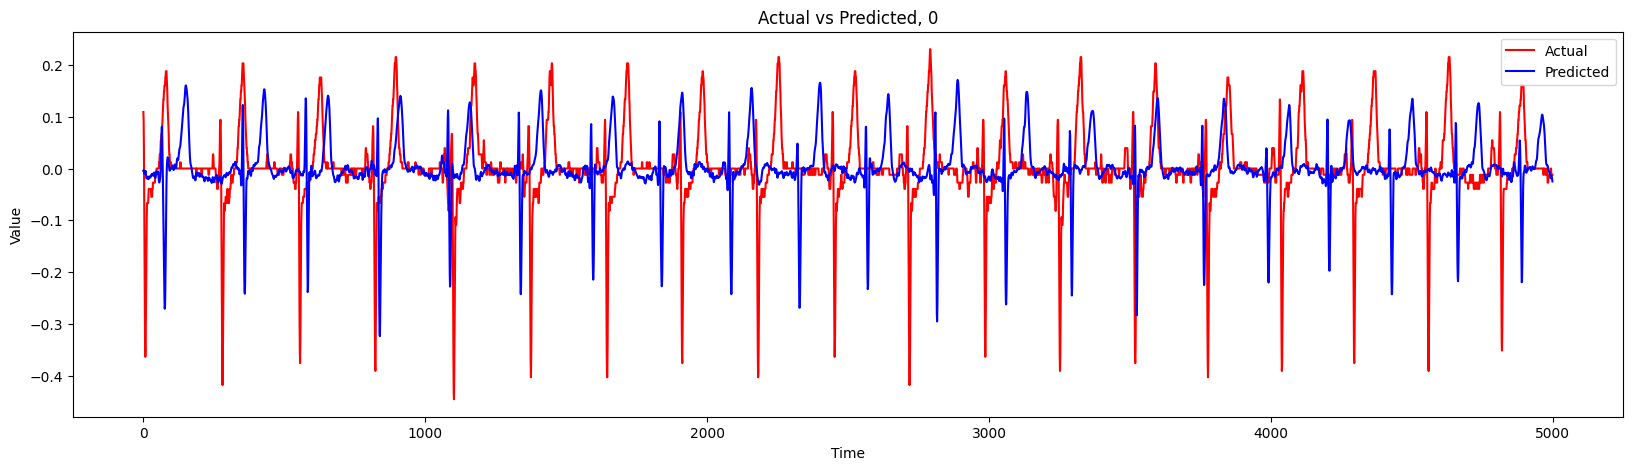

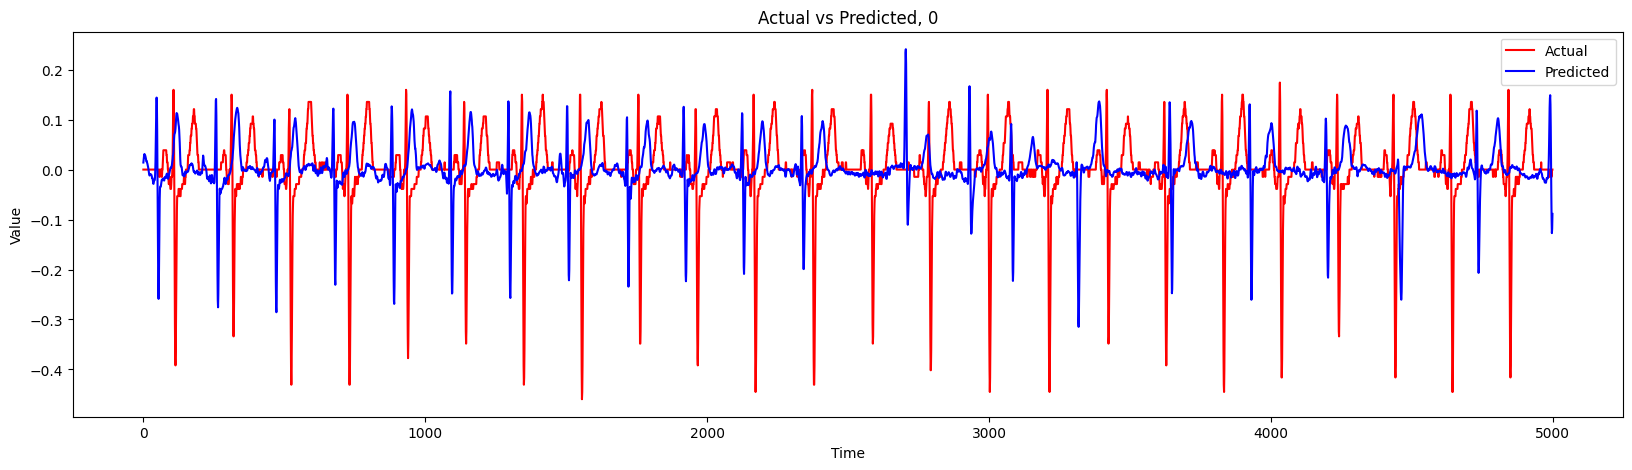

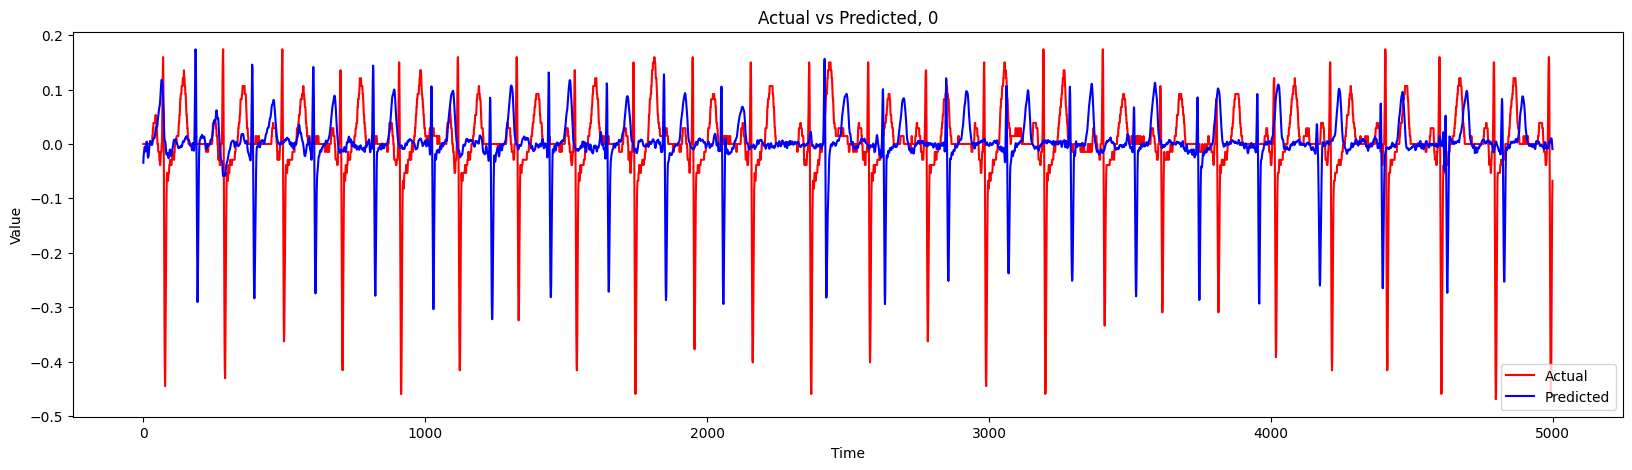

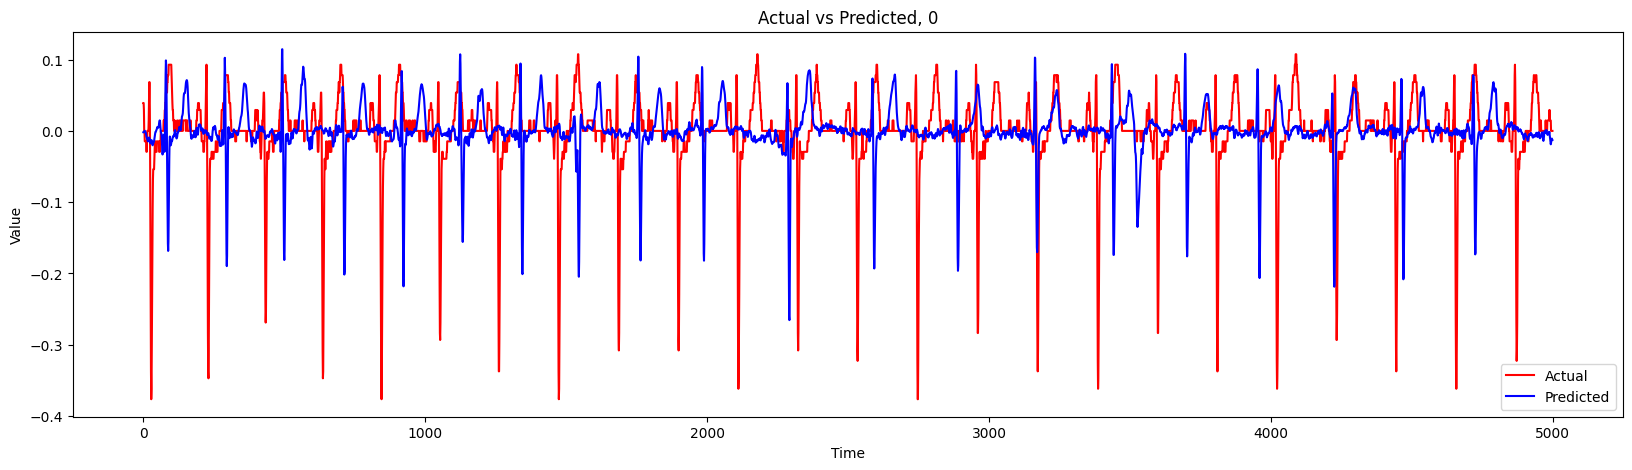

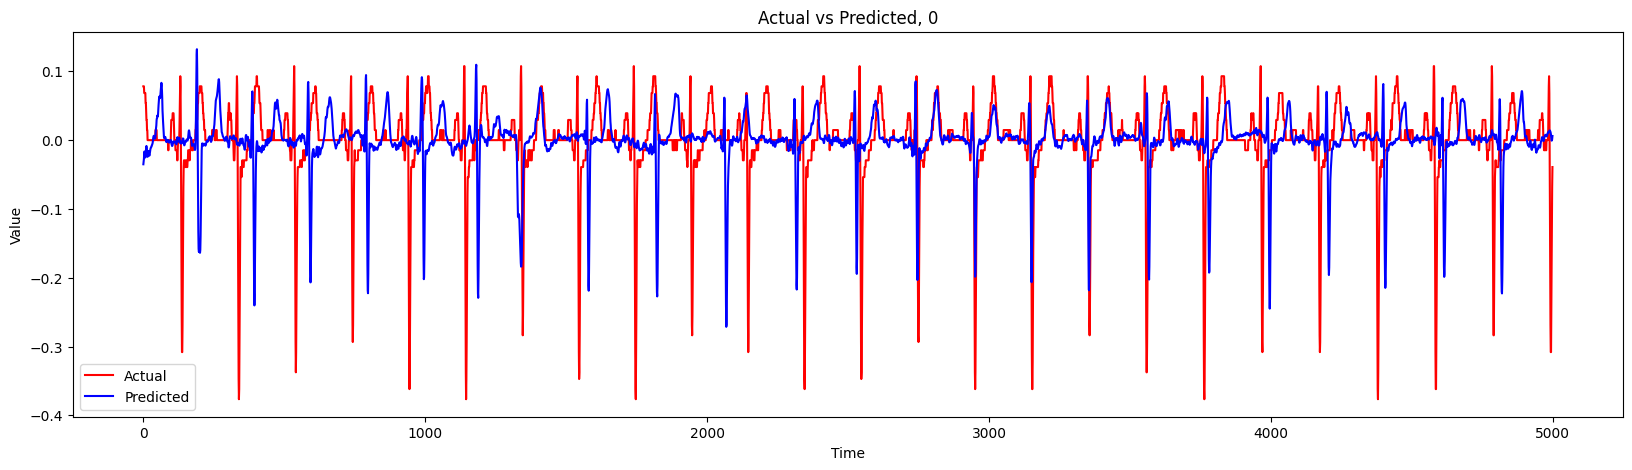

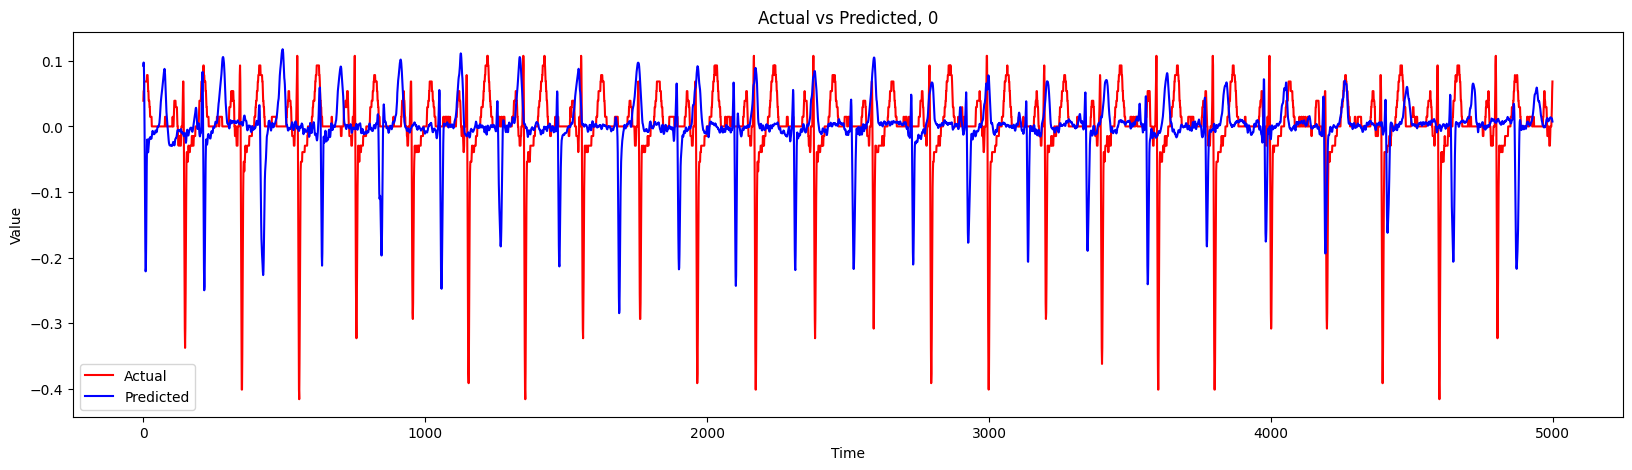

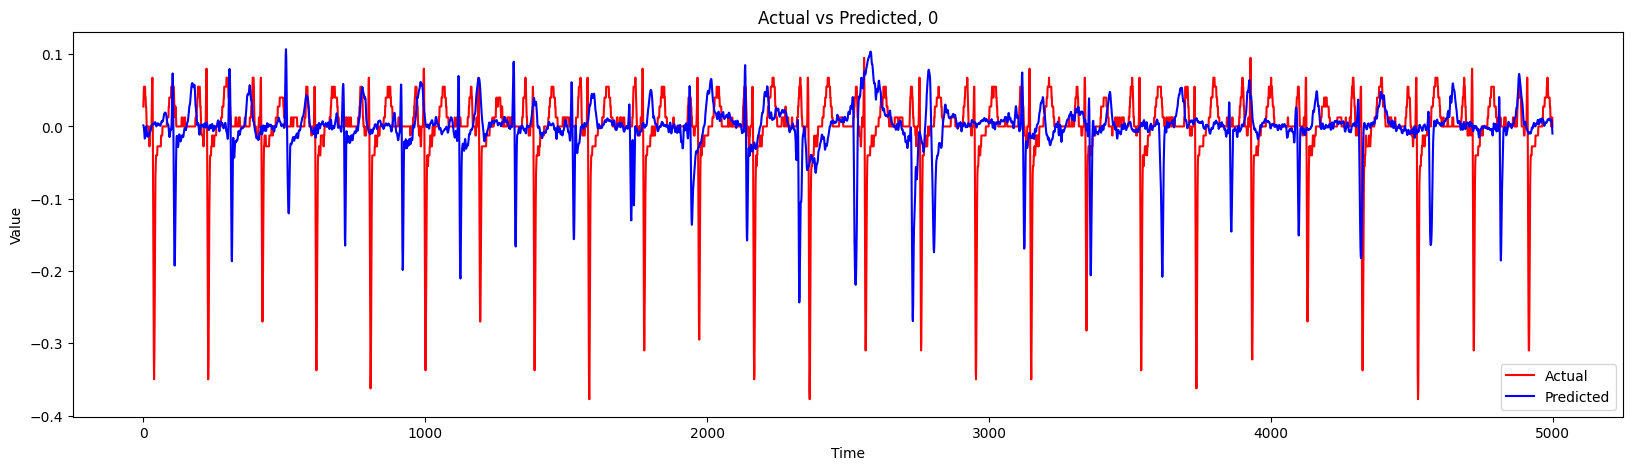

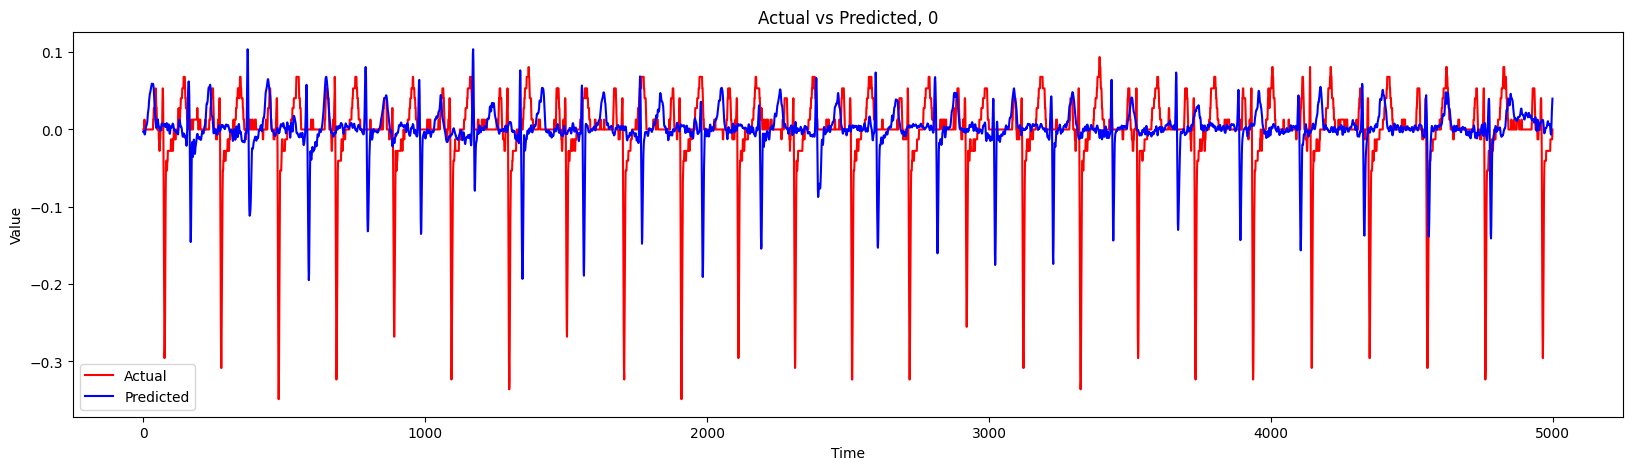

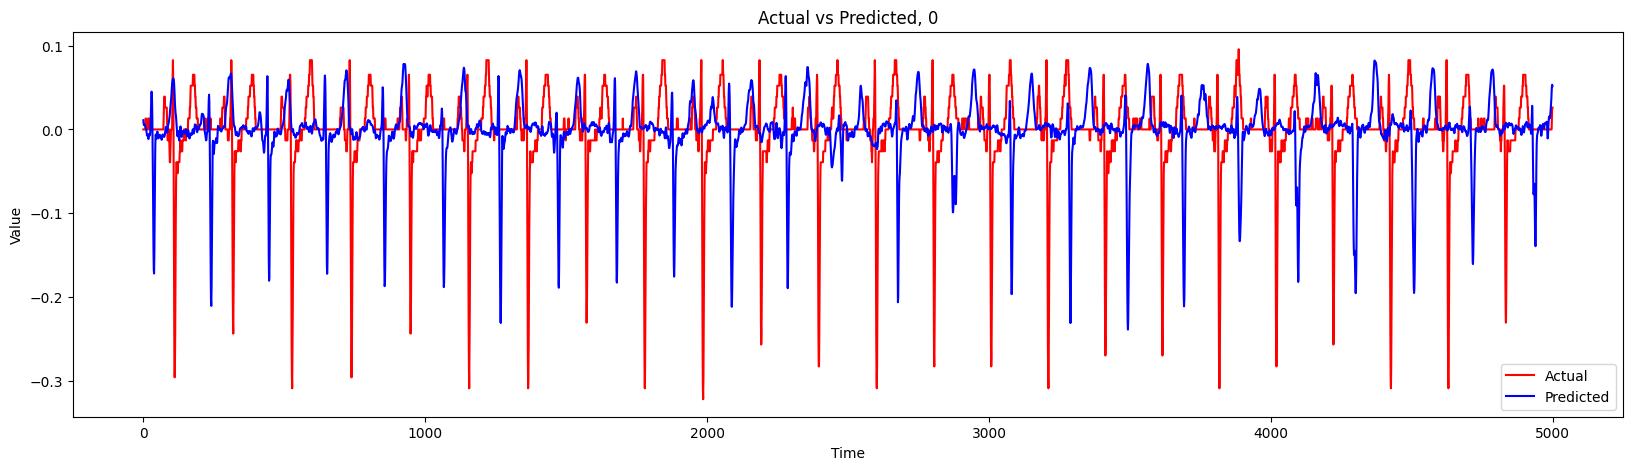

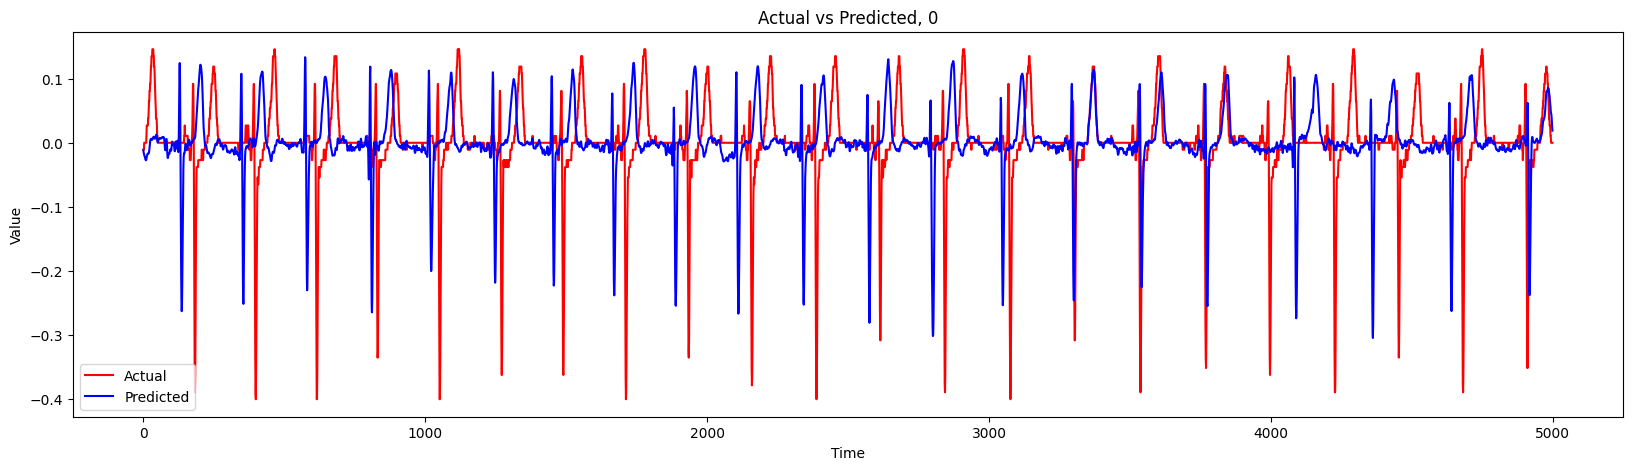

100%|██████████| 1/1 [06:54<00:00, 414.07s/it]


In [16]:
context = data[..., :context_window_size]
specific_chpt_path = \
"/home/liranc6/ecg_forecasting/liran_project/results/icentia11k/SSSDS4/context5000_label5000/T200_beta000001_betaT002/11_42_13_07_24_13z7z5hl/13z7z5hl_best_model:_iter:_198.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/13z7z5hl_best_model__iter__169.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/ywwhgg9f_best_model__iter__93.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/ywwhgg9f_best_model__iter__78.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/context5000_label5000_15_40_05_07_24best_model__iter__95.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/clean-yogurt-best_model__iter__12.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/context3748_label2500T200_115.pkl"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/context7500_label2500T_19_35_25_06_24best_model_iter_63_loss_0.09594888137755814.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/84.pkl"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/108.pkl"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/context3748_label1248T200_beta000001_betaT00218_44_10_06_24144.pkl"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results_from_newton/context3748_label1248T200_beta000001_betaT00217_56_10_06_2472"

inference_label_window_size =  label_window_size
num_window_to_pred = 1

predicted_ecg = autoegressive_predictor(server = SERVER,
                                        config_file = config_file,
                                        ckpt_path = specific_chpt_path, #gen_config["ckpt_path_rambo"],
                                        ckpt_iter = "55",
                                        # use_model= train_config["use_model"],
                                        context=context,
                                        label_size=label_window_size,
                                        step_size= inference_label_window_size,#int(label_window_size/2),
                                        num_window_to_pred=num_window_to_pred,
                                        diffusion_hyperparams=diffusion_hyperparams,
                                        only_generate_missing=train_config["only_generate_missing"],
                                        specific_chpt_path= specific_chpt_path
                                        )

In [17]:
checkpoint = torch.load(specific_chpt_path)
checkpoint.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'wandb_id', 'dtw_dist', 'mse_ecg_signals', 'modified_chamfer_distance', 'mean_extra_r_beats', 'mean_extra_r_beats_negligible_length', 'mae_pruned_r_beats_localization'])

In [18]:
predicted_ecg.size()

torch.Size([10, 10000])

In [19]:
def visualize_prediction(actual, predicted, num):
    plt.figure(figsize=(20, 5))  # Adjust the figure size and DPI
    plt.plot(actual, color='red', label='Actual')  # Plot the actual data in blue
    if predicted is not None:
        plt.plot(predicted, color='blue', label='Predicted')  # Plot the predicted data in red
    plt.title(f'Actual vs Predicted, {num}')  # Set the title of the plot
    plt.xlabel('Time')  # Set the label for the x-axis
    plt.ylabel('Value')  # Set the label for the y-axis
    plt.legend()  # Show the legend
    plt.show()  # Display the plot

In [20]:
#61 works well

In [21]:
# normalizer = liran_train.NormalizeBatch(input=True)
# normalized_data = normalizer((data.unsqueeze(1), None, None))[0].squeeze(1)
normalized_data = data

In [22]:
# predicted_ecg.size()
# normalized_data.size()


In [23]:
# advance -= context_window_size

In [24]:
# advance

pred.size()=torch.Size([5000])


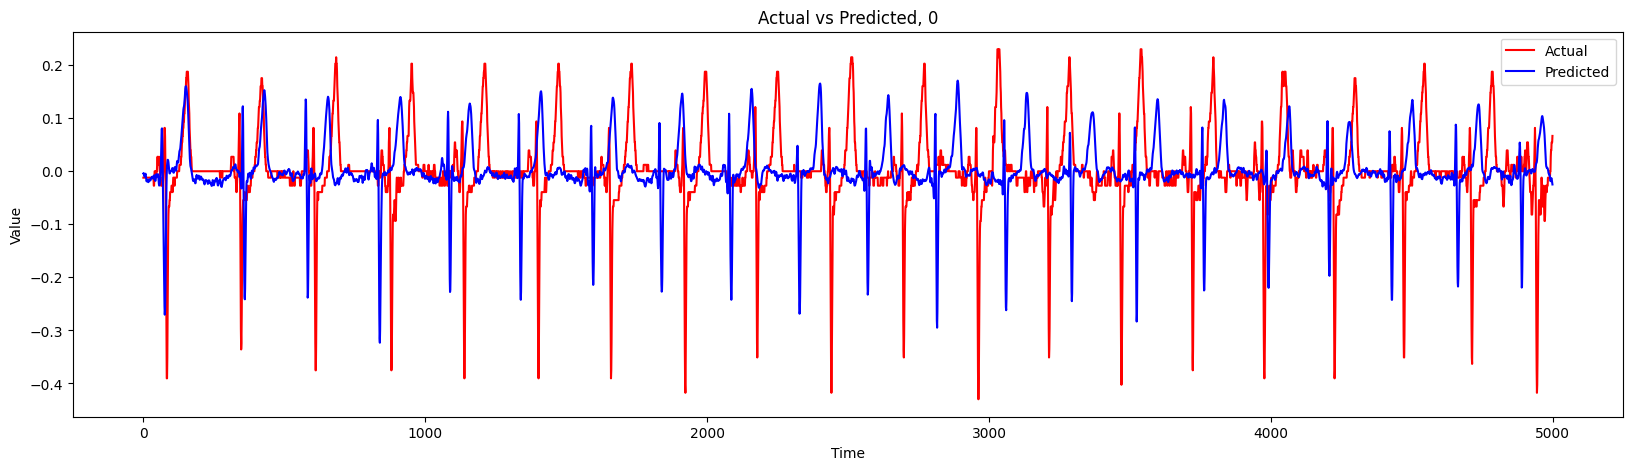

pred.size()=torch.Size([5000])


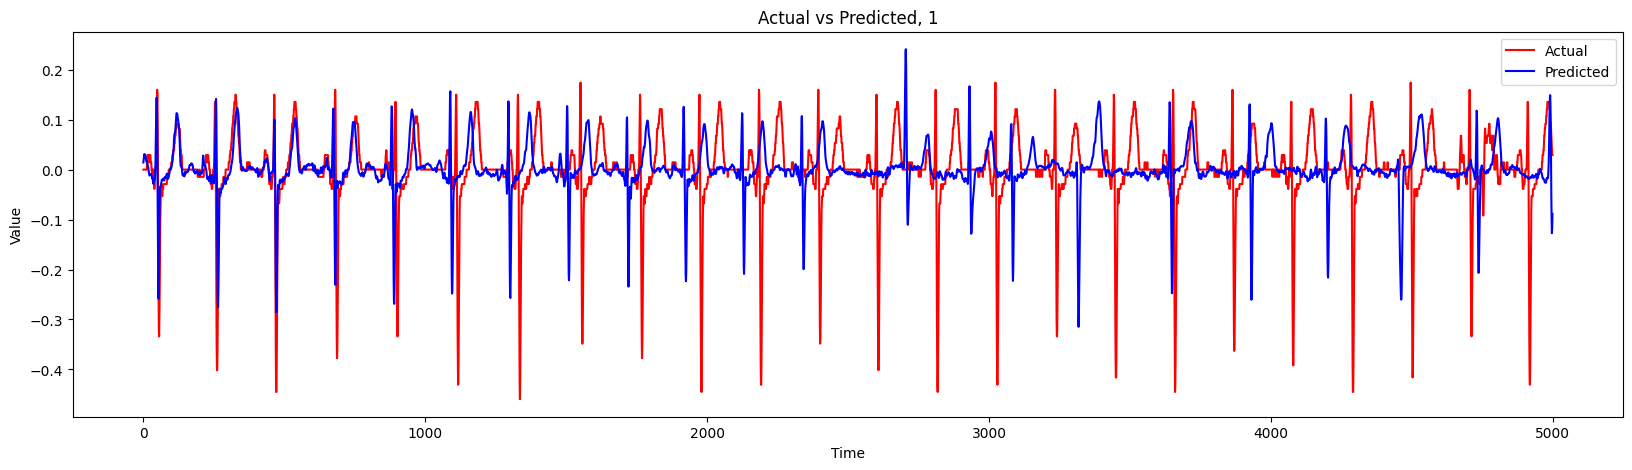

pred.size()=torch.Size([5000])


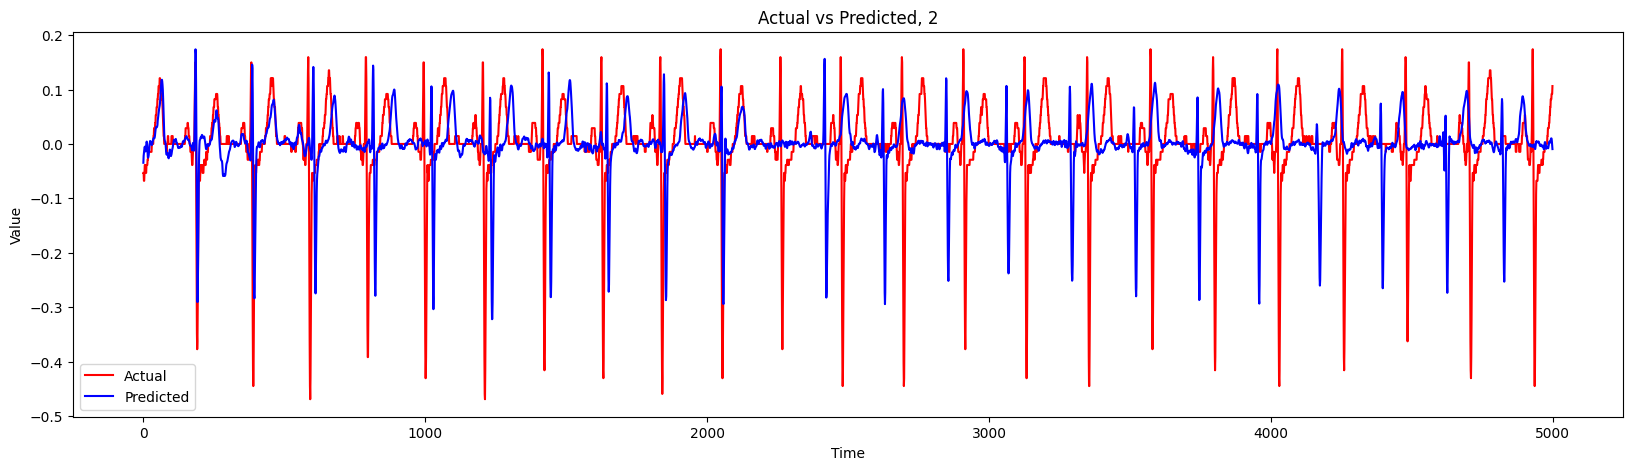

pred.size()=torch.Size([5000])


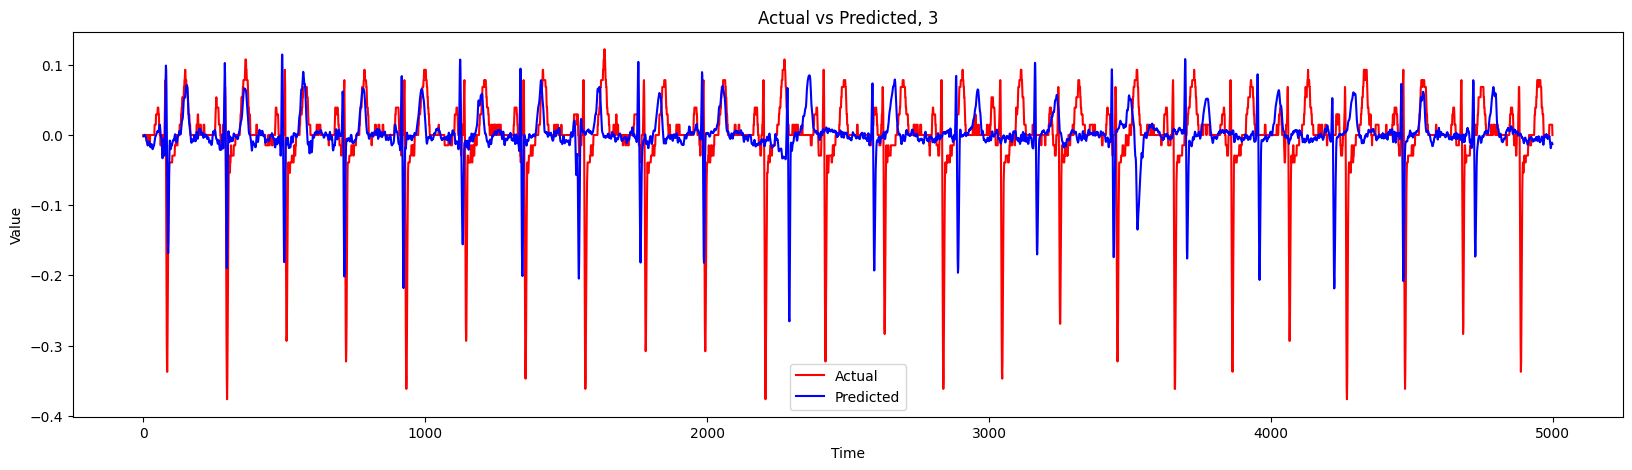

pred.size()=torch.Size([5000])


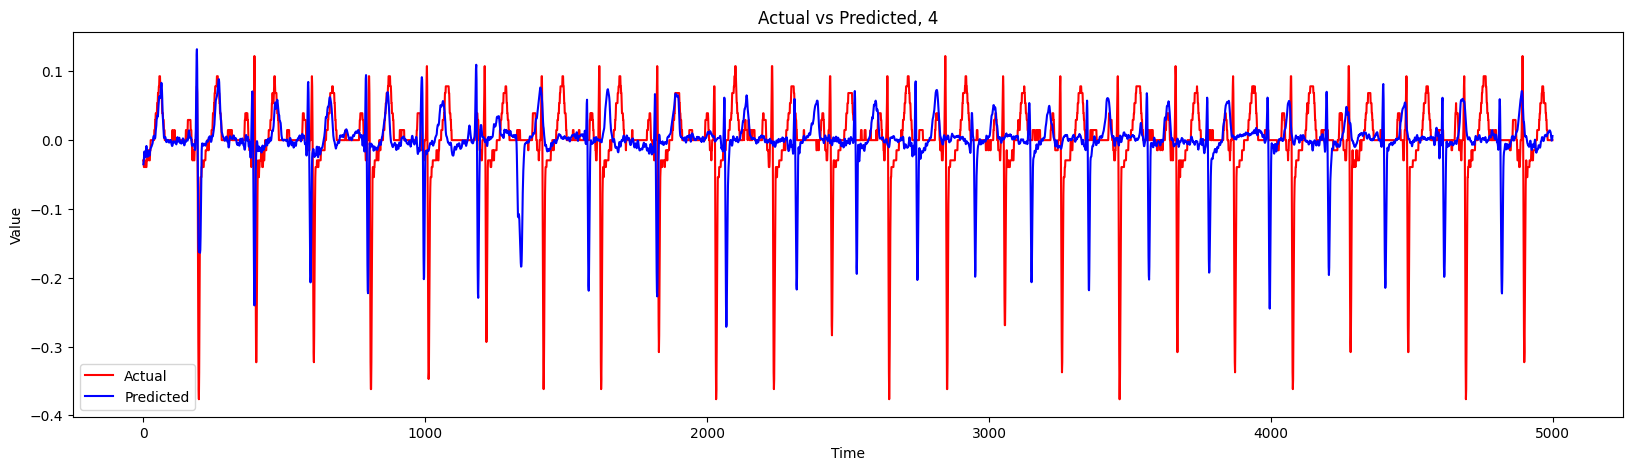

pred.size()=torch.Size([5000])


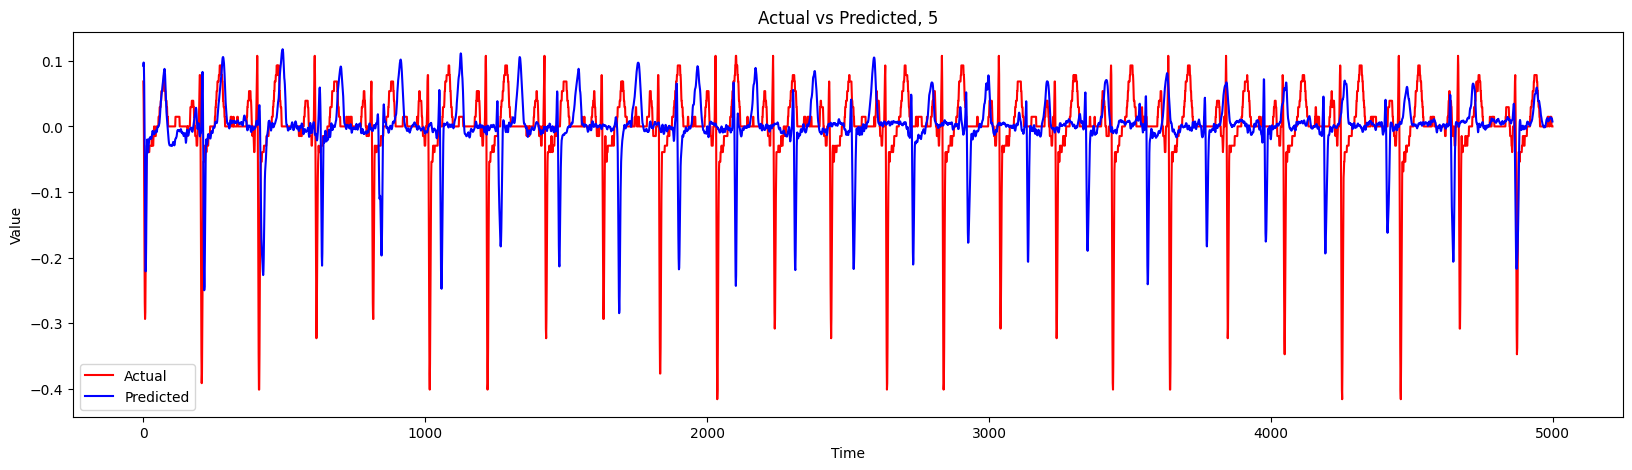

pred.size()=torch.Size([5000])


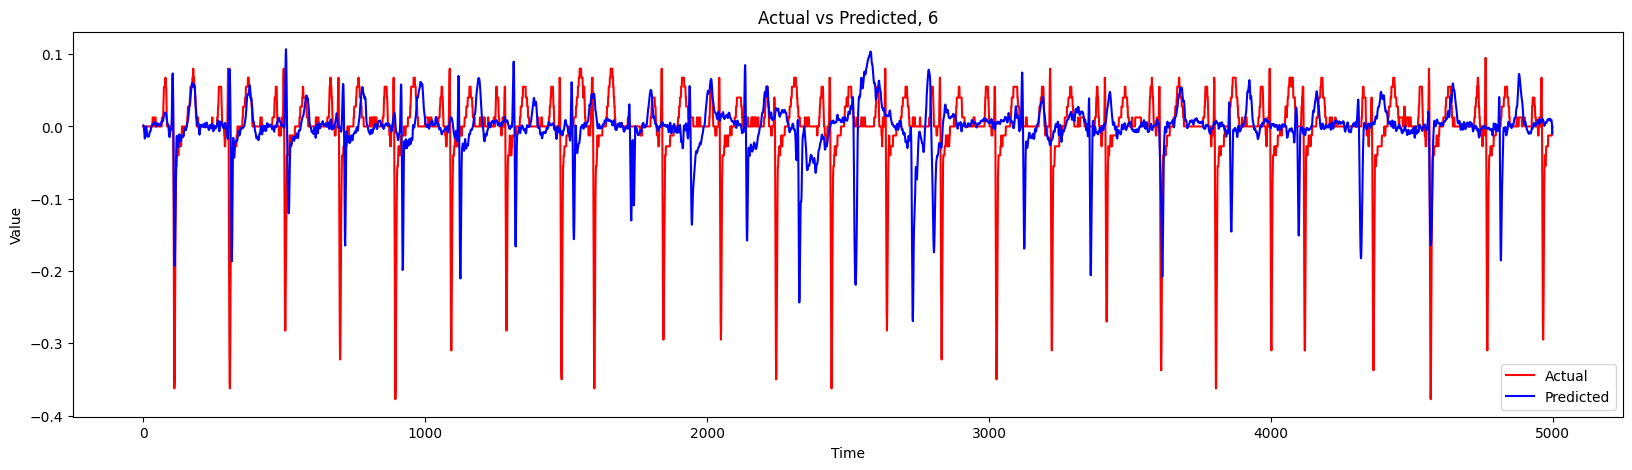

pred.size()=torch.Size([5000])


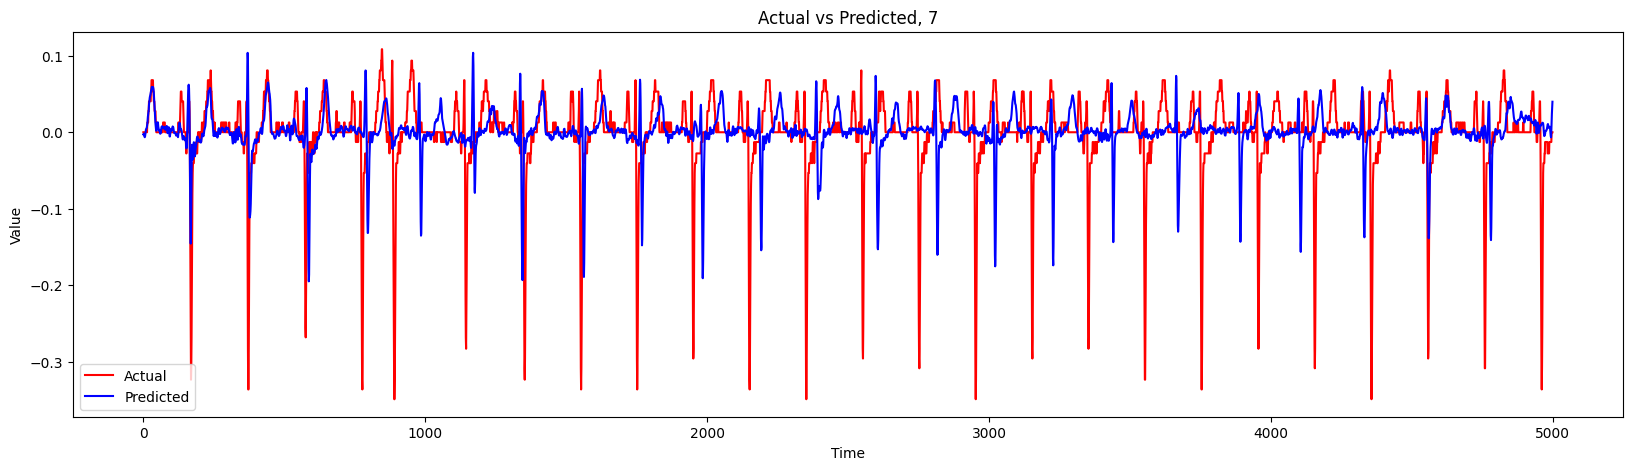

pred.size()=torch.Size([5000])


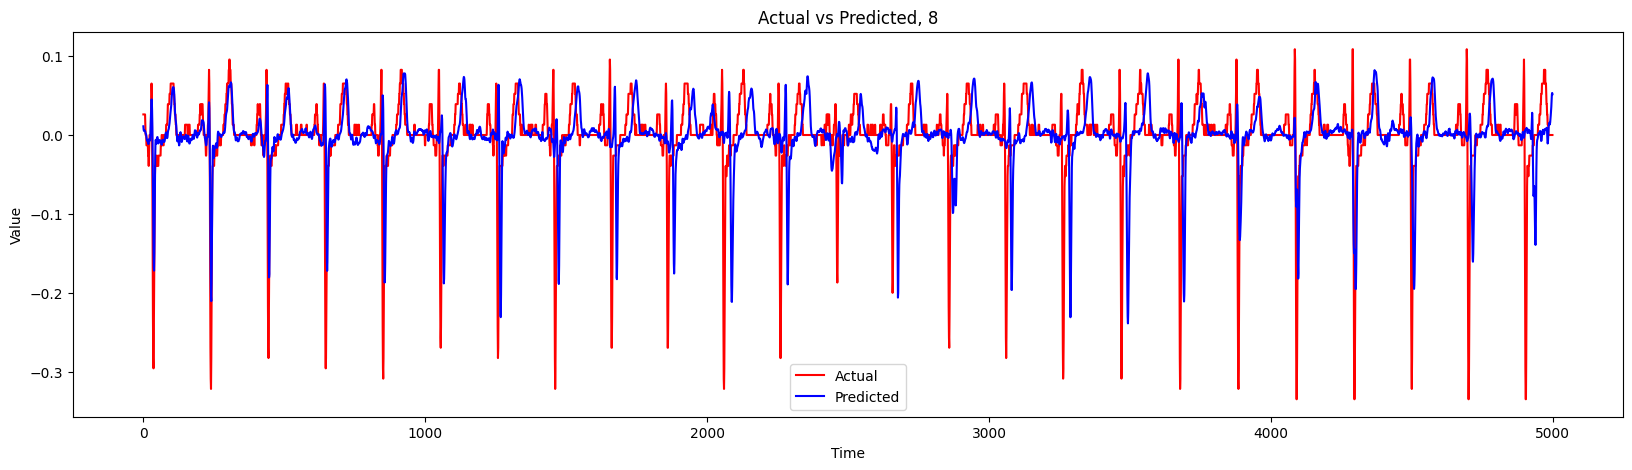

pred.size()=torch.Size([5000])


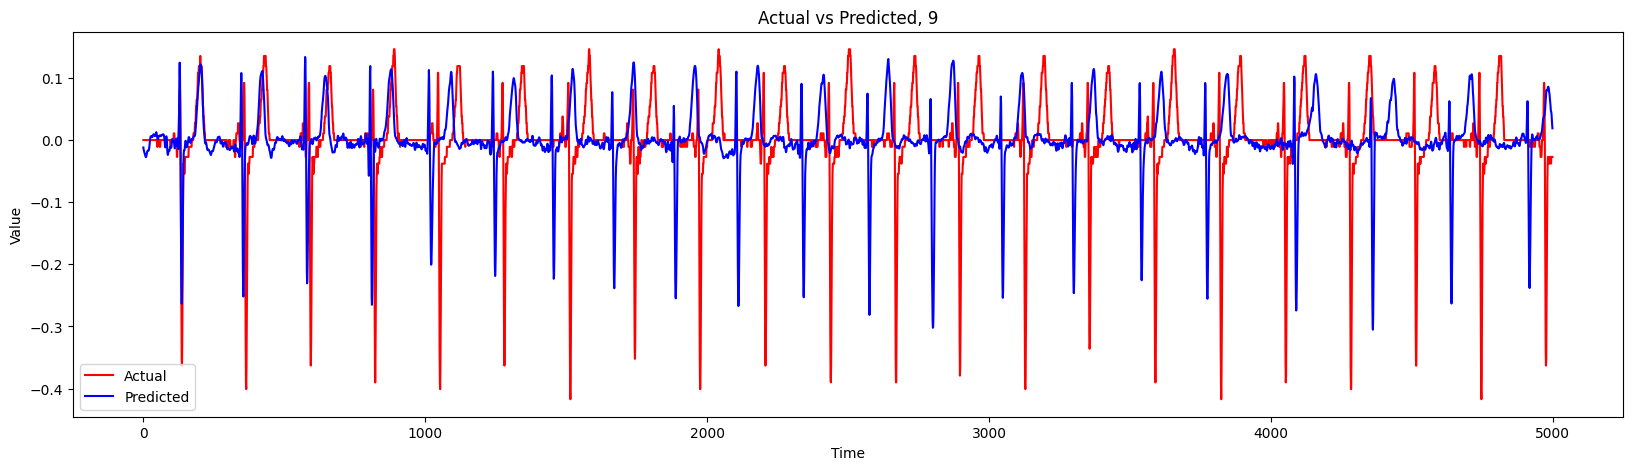

In [25]:
duration = inference_label_window_size*num_window_to_pred
advance = context_window_size
i = 0
for sample, pred in zip(normalized_data, predicted_ecg):
    # if i not in [2,4, 7]:
    #     i+=1
    #     continue
    sample = sample[advance : advance + duration]
    pred = pred[advance : advance + duration]
    print(f"{pred.size()=}")
    visualize_prediction(actual=sample, predicted=pred, num=i)
    i+=1

In [26]:
inference_label_window_size =  label_window_size // 5
num_window_to_pred = 5

predicted_ecg = autoegressive_predictor(config_file = config_file,
                                        ckpt_path = specific_chpt_path, #gen_config["ckpt_path_rambo"],
                                        ckpt_iter = "55",
                                        # use_model= train_config["use_model"],
                                        context=context,
                                        label_size=label_window_size,
                                        step_size= inference_label_window_size,#int(label_window_size/2),
                                        num_window_to_pred=num_window_to_pred,
                                        diffusion_hyperparams=diffusion_hyperparams,
                                        only_generate_missing=train_config["only_generate_missing"],
                                        specific_chpt_path= specific_chpt_path
                                        )

FileNotFoundError: [Errno 2] No such file or directory: '/home/liranc6/ecg/ecg_forecasting/SSSD_main/src/config/config_SSSDS4.json'

In [ ]:
duration = inference_label_window_size*num_window_to_pred
advance = context_window_size
i = 0
for sample, pred in zip(normalized_data, predicted_ecg):
    # if i not in [2,4, 7]:
    #     i+=1
    #     continue
    sample = sample[advance : advance + duration]
    pred = pred[advance : advance + duration]
    print(f"{pred.size()=}")
    visualize_prediction(actual=sample, predicted=pred, num=i)
    i+=1